In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')

import warnings
warnings.filterwarnings('ignore')

In [2]:
class PathAwareDense(Layer):
    def __init__(self, units, layer_id, activation='relu', **kwargs):
        super(PathAwareDense, self).__init__(**kwargs)
        self.units = units
        self.layer_id = layer_id
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
        # Информационная ценность каждого нейрона
        self.neuron_value = self.add_weight(
            shape=(self.units,),
            initializer='ones',
            trainable=False,
            name='neuron_value'
        )
        # Счетчик активаций
        self.activation_count = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=False,
            name='activation_count'
        )
        
    def call(self, inputs, training=None):
        # Вычисляем взвешенный выход
        output = tf.matmul(inputs, self.kernel * self.neuron_value) + self.bias
        activated_output = self.activation(output)
        
        if training:
            # Обновляем статистику активаций
            batch_activations = tf.reduce_mean(tf.cast(activated_output > 0.1, tf.float32), axis=0)
            self.activation_count.assign_add(batch_activations)
            
            # Обновляем информационную ценность на основе активаций и величины весов
            activation_ratio = self.activation_count / tf.reduce_max(self.activation_count)
            weight_magnitude = tf.reduce_mean(tf.abs(self.kernel), axis=0)
            
            # Комбинированная метрика информационной ценности
            new_value = 0.7 * activation_ratio + 0.3 * weight_magnitude
            self.neuron_value.assign(new_value)
        
        return activated_output

class PathAwareModel(Sequential):
    def __init__(self, **kwargs):
        super(PathAwareModel, self).__init__(**kwargs)
        self.layer_graph = nx.DiGraph()
        self.best_path = None
        self.path_strength = 0
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_losses = []
        self.val_losses = []
        self.path_strengths = []
        
    def build_path_network(self):
        """Построение графа нейронной сети"""
        self.layer_graph.clear()
        
        # Добавляем узлы для входного слоя
        input_size = self.layers[0].kernel.shape[0]
        for i in range(input_size):
            self.layer_graph.add_node(f'input_{i}', value=1.0, layer=0)
        
        # Добавляем узлы и связи для скрытых слоев
        for layer_idx, layer in enumerate(self.layers):
            if hasattr(layer, 'neuron_value'):
                for neuron_idx in range(layer.units):
                    node_id = f'l{layer_idx}_n{neuron_idx}'
                    self.layer_graph.add_node(node_id, 
                                           value=layer.neuron_value[neuron_idx].numpy(),
                                           layer=layer_idx + 1)
                    
                    # Связи с предыдущим слоем
                    if layer_idx == 0:
                        # Связь с входным слоем
                        for prev_neuron in range(input_size):
                            weight = layer.kernel[prev_neuron, neuron_idx].numpy()
                            if abs(weight) > 0.01:  # Только значимые связи
                                self.layer_graph.add_edge(f'input_{prev_neuron}', node_id, 
                                                        weight=abs(weight))
                    else:
                        # Связь с предыдущим скрытым слоем
                        prev_layer = self.layers[layer_idx - 1]
                        for prev_neuron in range(prev_layer.units):
                            weight = layer.kernel[prev_neuron, neuron_idx].numpy()
                            if abs(weight) > 0.01:  # Только значимые связи
                                self.layer_graph.add_edge(f'l{layer_idx-1}_n{prev_neuron}', node_id, 
                                                        weight=abs(weight))
        
        # Добавляем выходной слой
        output_layer = self.layers[-1]
        for neuron_idx in range(output_layer.units):
            node_id = f'output_{neuron_idx}'
            self.layer_graph.add_node(node_id, value=1.0, layer=len(self.layers))
            
            # Связи с последним скрытым слоем
            last_hidden = self.layers[-2]
            for prev_neuron in range(last_hidden.units):
                weight = output_layer.kernel[prev_neuron, neuron_idx].numpy()
                if abs(weight) > 0.01:
                    self.layer_graph.add_edge(f'l{len(self.layers)-2}_n{prev_neuron}', node_id, 
                                            weight=abs(weight))
    
    def find_strongest_path(self):
        """Поиск наиболее сильного пути через сеть"""
        self.build_path_network()
        
        strongest_path = None
        max_strength = -1
        
        # Поиск путей от входных нейронов к выходным
        input_nodes = [n for n in self.layer_graph.nodes if self.layer_graph.nodes[n]['layer'] == 0]
        output_nodes = [n for n in self.layer_graph.nodes if self.layer_graph.nodes[n]['layer'] == len(self.layers)]
        
        for start_node in input_nodes:
            for end_node in output_nodes:
                try:
                    # Находим все простые пути
                    for path in nx.all_simple_paths(self.layer_graph, start_node, end_node):
                        path_strength = 1.0
                        # Вычисляем силу пути как произведение весов связей и ценностей нейронов
                        for i in range(len(path) - 1):
                            edge_weight = self.layer_graph[path[i]][path[i+1]]['weight']
                            neuron_value = self.layer_graph.nodes[path[i+1]]['value']
                            path_strength *= edge_weight * neuron_value
                        
                        if path_strength > max_strength:
                            max_strength = path_strength
                            strongest_path = path
                except nx.NetworkXNoPath:
                    continue
        
        self.best_path = strongest_path
        self.path_strength = max_strength
        return strongest_path, max_strength
    
    def enhance_path_weights(self, enhancement_factor=1.1):
        """Усиление весов вдоль найденного пути"""
        if self.best_path is None:
            return
        
        for i in range(len(self.best_path) - 1):
            node_from = self.best_path[i]
            node_to = self.best_path[i+1]
            
            # Определяем, к какому слою принадлежит связь
            if 'l' in node_to:
                layer_idx = int(node_to.split('_')[0][1:])
                neuron_to_idx = int(node_to.split('_')[1][1:])
                
                if 'input' in node_from:
                    # Связь вход-первый слой
                    neuron_from_idx = int(node_from.split('_')[1])
                    current_weight = self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx]
                    enhanced_weight = current_weight * enhancement_factor
                    self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx].assign(enhanced_weight)
                else:
                    # Связь между скрытыми слоями
                    neuron_from_idx = int(node_from.split('_')[1][1:])
                    current_weight = self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx]
                    enhanced_weight = current_weight * enhancement_factor
                    self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx].assign(enhanced_weight)

In [3]:
# Генерация синтетических данных
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, 
                          n_informative=15, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Создание модели с поиском пути
model = PathAwareModel()
model.add(PathAwareDense(12, layer_id=0, input_dim=X_train.shape[1], activation='relu'))
model.add(PathAwareDense(8, layer_id=1, activation='relu'))
model.add(PathAwareDense(6, layer_id=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение с поиском и усилением путей
epochs = 50
batch_size = 3

# Создаем валидационный набор
X_val = X_train[-200:]
y_val = y_train[-200:]
X_train = X_train[:-200]
y_train = y_train[:-200]

In [4]:
for epoch in range(epochs):
    print(f"\nЭпоха {epoch + 1}/{epochs}")
    
    # Обучаем на одном батче
    history = model.fit(X_train, y_train,
                       epochs=1,
                       batch_size=batch_size,
                       validation_data=(X_val, y_val),
                       verbose=0)
    
    # Сохраняем метрики
    model.train_accuracies.append(history.history['accuracy'][0])
    model.val_accuracies.append(history.history['val_accuracy'][0])
    model.train_losses.append(history.history['loss'][0])
    model.val_losses.append(history.history['val_loss'][0])
    
    # Поиск и усиление наиболее сильного пути
    best_path, path_strength = model.find_strongest_path()
    model.path_strengths.append(path_strength)
    
    if best_path:
        print(f"Найден путь силы {path_strength:.4f}")
        print(f"Путь: {' -> '.join(best_path[:3])}...")  # Показываем только начало пути
        model.enhance_path_weights(enhancement_factor=1.05)
    else:
        print("Путь не найден")
    
    print(f"Точность: {model.train_accuracies[-1]:.4f}, Валидация: {model.val_accuracies[-1]:.4f}")

# Финальная оценка
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nФинальная тестовая точность: {test_accuracy:.4f}")


Эпоха 1/50
Найден путь силы 0.0281
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.5850, Валидация: 0.6150

Эпоха 2/50
Найден путь силы 0.0418
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.6900, Валидация: 0.7500

Эпоха 3/50
Найден путь силы 0.0585
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.8200, Валидация: 0.8250

Эпоха 4/50
Найден путь силы 0.0784
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.8700, Валидация: 0.8700

Эпоха 5/50
Найден путь силы 0.1096
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.9100, Валидация: 0.9100

Эпоха 6/50
Найден путь силы 0.1356
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.9283, Валидация: 0.9200

Эпоха 7/50
Найден путь силы 0.1625
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.9383, Валидация: 0.9050

Эпоха 8/50
Найден путь силы 0.1893
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.9467, Валидация: 0.9150

Эпоха 9/50
Найден путь силы 0.2217
Путь: input_0 -> l0_n2 -> l1_n4...
Точность: 0.9483, Валидация: 0.9300

Эпоха 10/50
Найден путь силы 0.2579


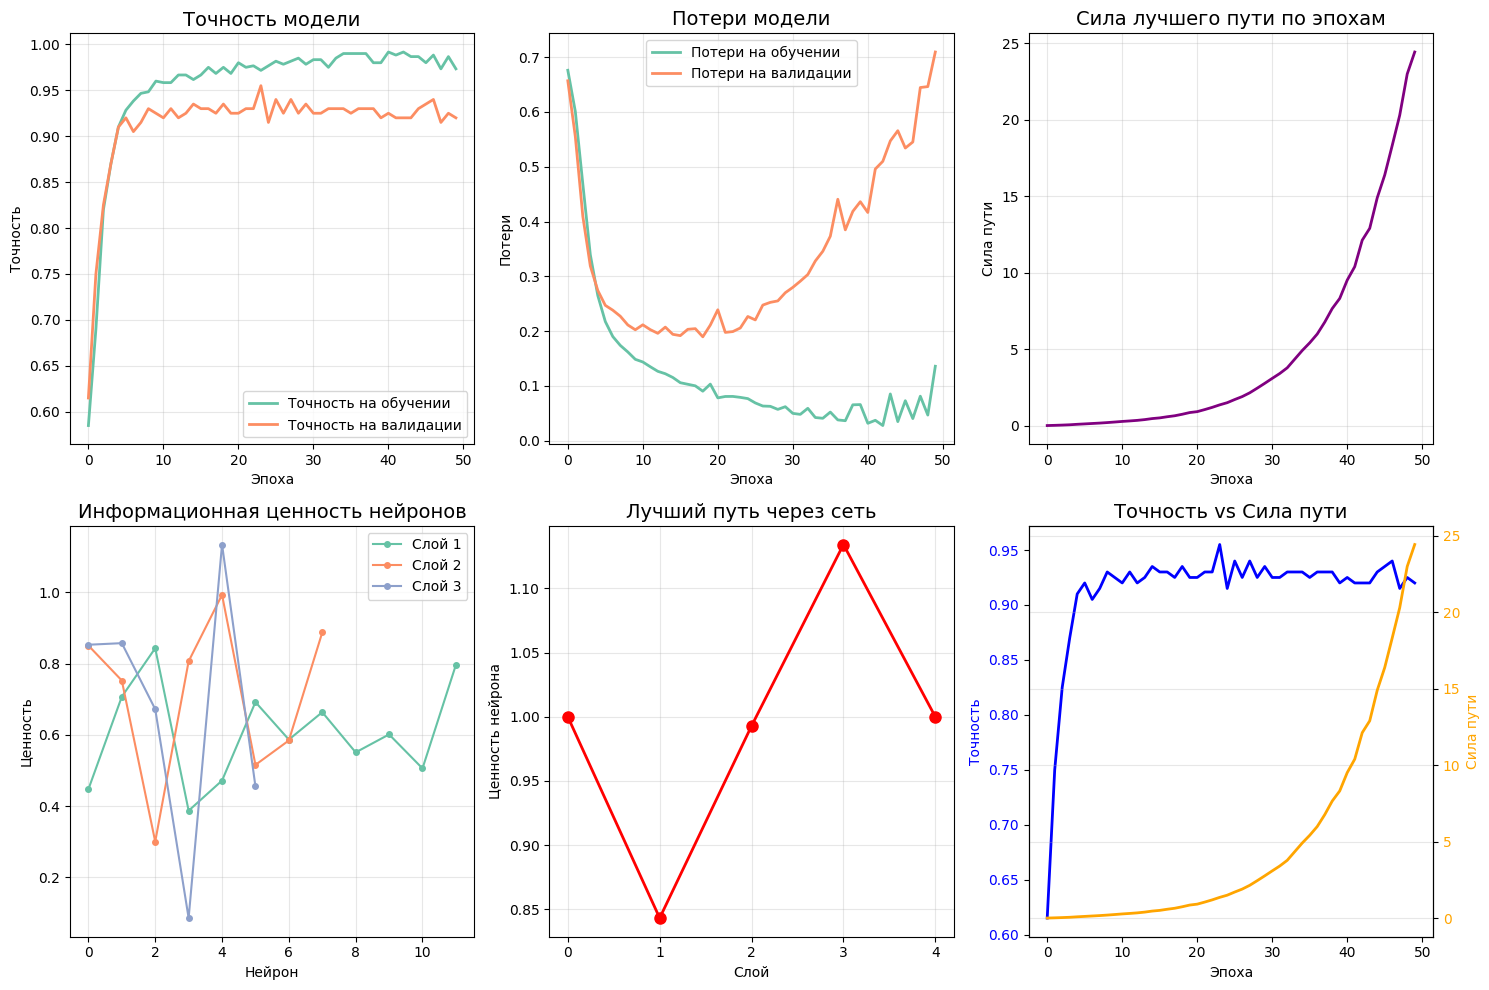


Анализ лучшего пути:
input_0: слой 0, ценность 1.0000
l0_n2: слой 1, ценность 0.8433
l1_n4: слой 2, ценность 0.9929
l2_n4: слой 3, ценность 1.1342
output_0: слой 4, ценность 1.0000


In [9]:
# Визуализация истории обучения
plt.figure(figsize=(15, 10))

# График точности
plt.subplot(2, 3, 1)
plt.plot(model.train_accuracies, label='Точность на обучении', linewidth=2)
plt.plot(model.val_accuracies, label='Точность на валидации', linewidth=2)
plt.title('Точность модели', fontsize=14)
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True, alpha=0.3)

# График потерь
plt.subplot(2, 3, 2)
plt.plot(model.train_losses, label='Потери на обучении', linewidth=2)
plt.plot(model.val_losses, label='Потери на валидации', linewidth=2)
plt.title('Потери модели', fontsize=14)
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True, alpha=0.3)

# График силы пути
plt.subplot(2, 3, 3)
plt.plot(model.path_strengths, label='Сила лучшего пути', linewidth=2, color='purple')
plt.title('Сила лучшего пути по эпохам', fontsize=14)
plt.xlabel('Эпоха')
plt.ylabel('Сила пути')
plt.grid(True, alpha=0.3)

# Визуализация информационной ценности нейронов
plt.subplot(2, 3, 4)
for i, layer in enumerate(model.layers[:-1]):  # Пропускаем выходной слой
    if hasattr(layer, 'neuron_value'):
        values = layer.neuron_value.numpy()
        plt.plot(values, label=f'Слой {i+1}', marker='o', markersize=4)
plt.title('Информационная ценность нейронов', fontsize=14)
plt.xlabel('Нейрон')
plt.ylabel('Ценность')
plt.legend()
plt.grid(True, alpha=0.3)

# Визуализация лучшего пути
plt.subplot(2, 3, 5)
if model.best_path:
    path_layers = [model.layer_graph.nodes[node]['layer'] for node in model.best_path]
    path_values = [model.layer_graph.nodes[node]['value'] for node in model.best_path]
    plt.plot(path_layers, path_values, 'o-', linewidth=2, markersize=8, color='red')
    plt.title('Лучший путь через сеть', fontsize=14)
    plt.xlabel('Слой')
    plt.ylabel('Ценность нейрона')
    plt.xticks(range(len(model.layers) + 1))
    plt.grid(True, alpha=0.3)

# Соотношение точности и силы пути
plt.subplot(2, 3, 6)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(model.val_accuracies, label='Точность', color='blue', linewidth=2)
ax2.plot(model.path_strengths, label='Сила пути', color='orange', linewidth=2)

ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Точность', color='blue')
ax2.set_ylabel('Сила пути', color='orange')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')
plt.title('Точность vs Сила пути', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод информации о лучшем пути
if model.best_path:
    print("\nАнализ лучшего пути:")
    for i, node in enumerate(model.best_path):
        layer = model.layer_graph.nodes[node]['layer']
        value = model.layer_graph.nodes[node]['value']
        print(f"{node}: слой {layer}, ценность {value:.4f}")
        if i >= 5:  # Ограничиваем вывод
            print("...")
            break

In [20]:
def find_deviation_point_derivative(strengths, window=5, threshold=3):
    """
    Находит точку отклонения по изменению производной
    strengths: массив значений силы пути
    window: размер окна для сглаживания
    threshold: порог изменения наклона
    """
    # Сглаживаем данные
    smoothed = np.convolve(strengths, np.ones(window)/window, mode='valid')
    
    # Вычисляем производную (разность соседних значений)
    derivative = np.diff(smoothed)
    
    # Нормализуем производную
    derivative_norm = np.abs(derivative) / np.max(np.abs(derivative))
    
    # Находим точку, где производная резко меняется
    deviation_point = None
    for i in range(1, len(derivative_norm)):
        if abs(derivative_norm[i] - derivative_norm[i-1]) > threshold:
            deviation_point = i + window  # Корректируем индекс из-за сглаживания
            break
    
    return deviation_point

def find_deviation_point_fit(strengths, poly_degree=10, threshold=3):
    """
    Находит отклонение путем сравнения с полиномиальной аппроксимацией
    """
    x = np.arange(len(strengths))
    
    # Аппроксимируем гиперболической кривой (полином n-й степени)
    coefficients = np.polyfit(x, strengths, poly_degree)
    poly_fn = np.poly1d(coefficients)
    fitted_values = poly_fn(x)
    
    # Вычисляем отклонения
    deviations = np.abs(strengths - fitted_values) / fitted_values
    
    # Находим точку, где отклонение превышает порог
    deviation_point = None
    for i in range(len(deviations)):
        if deviations[i] > threshold:
            deviation_point = i
            break
    
    return deviation_point, fitted_values, deviations

In [21]:
def find_optimal_deviation_point(strengths):
    """Комбинированный метод для надежного определения точки отклонения"""
    # Метод 1: по производной
    point1 = find_deviation_point_derivative(strengths)
    
    # Метод 2: по аппроксимации
    point2, fitted_values, deviations = find_deviation_point_fit(strengths)
    
    # Выбираем наиболее раннюю точку
    if point1 is not None and point2 is not None:
        return min(point1, point2), fitted_values, deviations
    elif point1 is not None:
        return point1, fitted_values, deviations
    else:
        return point2, fitted_values, deviations

Явная точка отклонения не обнаружена


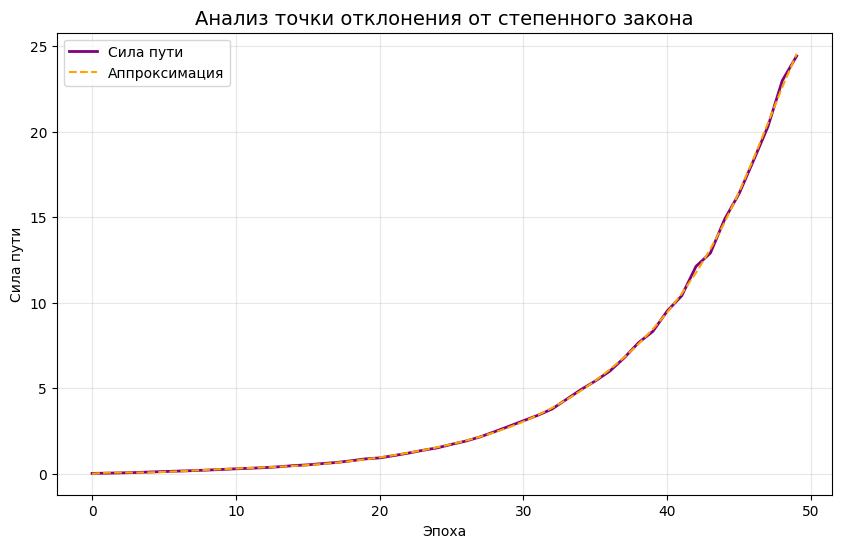

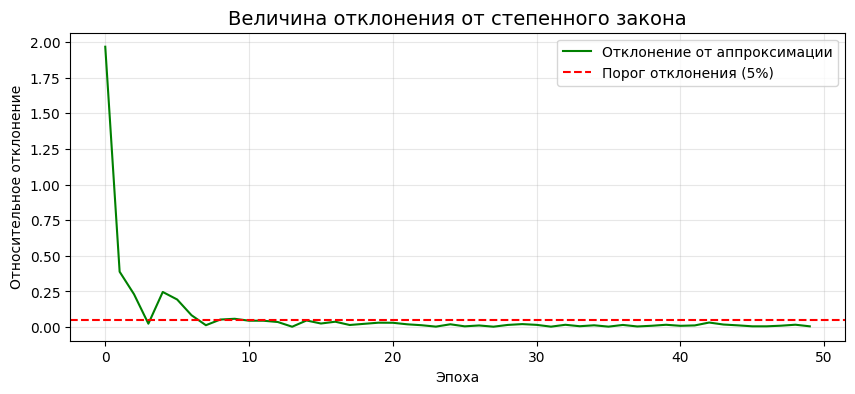

In [22]:
# После обучения добавляем анализ отклонения
deviation_epoch, fitted_values, deviations = find_optimal_deviation_point(model.path_strengths)

# Визуализация точки отклонения
plt.figure(figsize=(10, 6))
plt.plot(model.path_strengths, label='Сила пути', linewidth=2, color='purple')
plt.plot(fitted_values, label='Аппроксимация', linestyle='--', color='orange')

if deviation_epoch is not None:
    plt.axvline(x=deviation_epoch, color='red', linestyle=':', 
                label=f'Точка отклонения (эпоха {deviation_epoch})')
    print(f"Точка отклонения обнаружена на эпохе {deviation_epoch}")
    print(f"Сила пути в точке отклонения: {model.path_strengths[deviation_epoch]:.4f}")
else:
    print("Явная точка отклонения не обнаружена")

plt.title('Анализ точки отклонения от степенного закона', fontsize=14)
plt.xlabel('Эпоха')
plt.ylabel('Сила пути')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Дополнительный график отклонений
plt.figure(figsize=(10, 4))
plt.plot(deviations, label='Отклонение от аппроксимации', color='green')
plt.axhline(y=0.05, color='red', linestyle='--', label='Порог отклонения (5%)')
if deviation_epoch is not None:
    plt.axvline(x=deviation_epoch, color='red', linestyle=':')
plt.title('Величина отклонения от степенного закона', fontsize=14)
plt.xlabel('Эпоха')
plt.ylabel('Относительное отклонение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Анализ степенного закона для силы пути:
Точка отклонения от степенного закона: эпоха 46
Сила пути в точке отклонения: 16.3824
Параметры степенного закона: y = 0.0045 * x^1.9446
Коэффициент детерминации R²: 0.9023


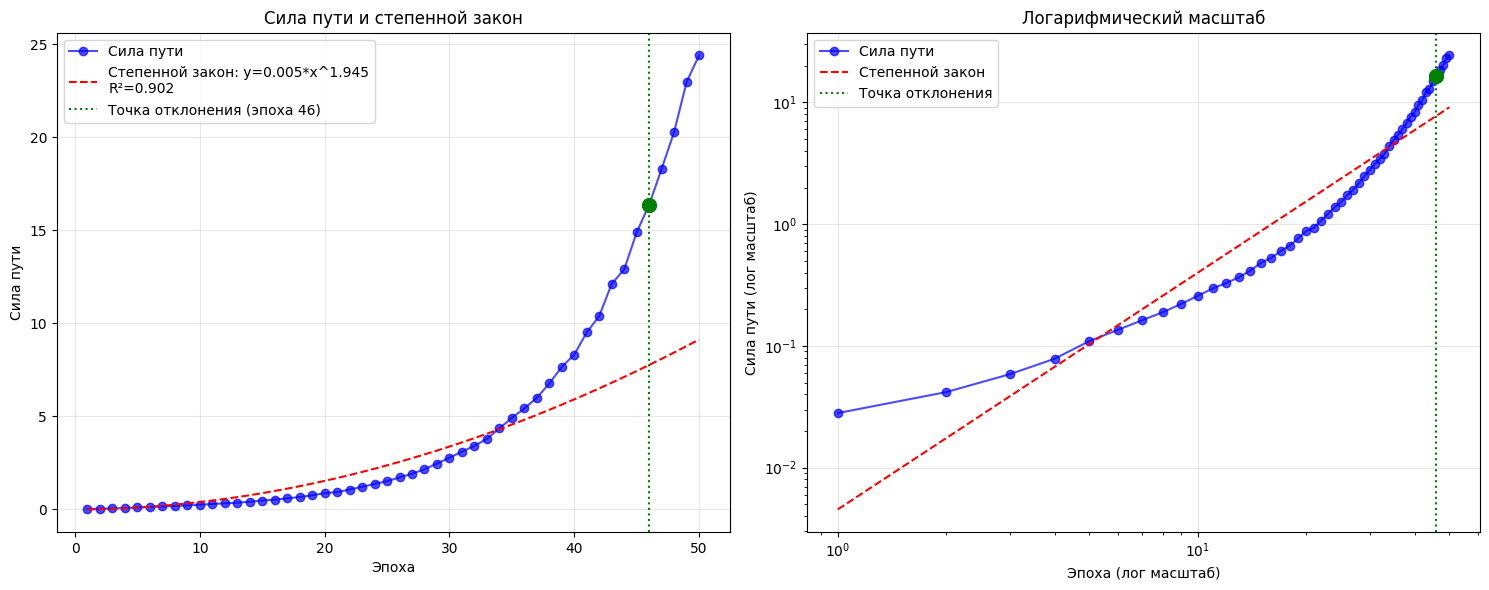


Анализ по сегментам:
Первая половина: R² = 0.9608
Вторая половина: R² = 0.8643


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

def find_power_law_deviation(path_strengths):
    """
    Находит точку отклонения от степенного закона в данных о силе пути
    
    Args:
        path_strengths: список значений силы пути по эпохам
    
    Returns:
        deviation_point: индекс точки отклонения
        power_law_params: параметры степенного закона (a, b для y = a*x^b)
        r_squared: коэффициент детерминации для степенного закона
    """
    
    # Преобразуем в numpy array и убираем нулевые/отрицательные значения
    strengths = np.array(path_strengths)
    valid_indices = np.where((strengths > 0) & (~np.isnan(strengths)) & (~np.isinf(strengths)))[0]
    
    if len(valid_indices) < 10:  # Слишком мало данных для анализа
        return None, None, None
    
    x = valid_indices + 1  # Эпохи (начинаем с 1)
    y = strengths[valid_indices]
    
    try:
        # Логарифмируем данные для линейной регрессии
        log_x = np.log(x)
        log_y = np.log(y)
        
        # Линейная регрессия в логарифмическом пространстве
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)
        
        # Параметры степенного закона: y = a*x^b
        b = slope
        a = np.exp(intercept)
        
        # Предсказанные значения по степенному закону
        y_pred = a * x**b
        
        # Вычисляем остатки (разницу между реальными и предсказанными значениями)
        residuals = y - y_pred
        
        # Вычисляем стандартное отклонение остатков
        std_residuals = np.std(residuals)
        
        # Находим точку, где остатки начинают систематически отклоняться
        # (когда остаток превышает 2 стандартных отклонения)
        deviation_mask = np.abs(residuals) > 2 * std_residuals
        
        # Находим первую точку значительного отклонения, которая сохраняется
        deviation_points = np.where(deviation_mask)[0]
        
        # Ищем точку, после которой отклонения становятся систематическими
        if len(deviation_points) > 0:
            # Берем первую точку, за которой следует несколько отклонений
            for i in range(len(deviation_points) - 3):
                if all(deviation_mask[deviation_points[i]:deviation_points[i]+3]):
                    deviation_point = deviation_points[i]
                    break
            else:
                deviation_point = deviation_points[0]
        else:
            deviation_point = None
        
        # Коэффициент детерминации R²
        r_squared = r_value**2
        
        return deviation_point, (a, b), r_squared
    
    except (ValueError, RuntimeWarning):
        return None, None, None

def plot_power_law_analysis(path_strengths):
    """
    Визуализирует анализ степенного закона и точку отклонения
    """
    strengths = np.array(path_strengths)
    valid_indices = np.where(strengths > 0)[0]
    x = valid_indices + 1
    y = strengths[valid_indices]
    
    # Находим точку отклонения
    deviation_point, params, r_squared = find_power_law_deviation(path_strengths)
    
    # Создаем график
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # График 1: Исходные данные и степенной закон
    ax1.plot(x, y, 'bo-', label='Сила пути', alpha=0.7)
    
    if params is not None:
        a, b = params
        y_pred = a * x**b
        ax1.plot(x, y_pred, 'r--', label=f'Степенной закон: y={a:.3f}*x^{b:.3f}\nR²={r_squared:.3f}')
        
        if deviation_point is not None:
            ax1.axvline(x=x[deviation_point], color='g', linestyle=':', 
                       label=f'Точка отклонения (эпоха {x[deviation_point]})')
            ax1.plot(x[deviation_point], y[deviation_point], 'go', markersize=10)
    
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Сила пути')
    ax1.set_title('Сила пути и степенной закон')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Логарифмический масштаб
    ax2.loglog(x, y, 'bo-', label='Сила пути', alpha=0.7)
    
    if params is not None:
        ax2.loglog(x, y_pred, 'r--', label='Степенной закон')
        
        if deviation_point is not None:
            ax2.axvline(x=x[deviation_point], color='g', linestyle=':', 
                       label='Точка отклонения')
            ax2.loglog(x[deviation_point], y[deviation_point], 'go', markersize=10)
    
    ax2.set_xlabel('Эпоха (лог масштаб)')
    ax2.set_ylabel('Сила пути (лог масштаб)')
    ax2.set_title('Логарифмический масштаб')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return deviation_point, params, r_squared

# Анализ ваших данных
if hasattr(model, 'path_strengths') and len(model.path_strengths) > 0:
    print("Анализ степенного закона для силы пути:")
    
    deviation_point, power_law_params, r_squared = find_power_law_deviation(model.path_strengths)
    
    if deviation_point is not None:
        print(f"Точка отклонения от степенного закона: эпоха {deviation_point + 1}")
        print(f"Сила пути в точке отклонения: {model.path_strengths[deviation_point]:.4f}")
    else:
        print("Значительное отклонение от степенного закона не обнаружено")
    
    if power_law_params is not None:
        a, b = power_law_params
        print(f"Параметры степенного закона: y = {a:.4f} * x^{b:.4f}")
        print(f"Коэффициент детерминации R²: {r_squared:.4f}")
    
    # Визуализация
    plot_power_law_analysis(model.path_strengths)
    
    # Дополнительный анализ: проверка качества подгонки по сегментам
    print("\nАнализ по сегментам:")
    strengths = np.array(model.path_strengths)
    valid_strengths = strengths[strengths > 0]
    
    if len(valid_strengths) > 20:
        # Первая половина данных
        first_half = valid_strengths[:len(valid_strengths)//2]
        dev_point1, params1, r1 = find_power_law_deviation(first_half)
        
        # Вторая половина данных
        second_half = valid_strengths[len(valid_strengths)//2:]
        dev_point2, params2, r2 = find_power_law_deviation(second_half)
        
        print(f"Первая половина: R² = {r1:.4f}")
        print(f"Вторая половина: R² = {r2:.4f}")
        
        if r1 > 0.9 and r2 < 0.7:
            print("→ Наблюдается ухудшение соответствия степенному закону во второй половине обучения")
else:
    print("Данные о силе пути отсутствуют или содержат только нулевые значения")